In [3]:
import gym
import numpy as np
from collections import deque
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math
import tensorflow_probability as tfp

### Plotting functions

In [5]:
def smooth(y, window, poly=1):
    '''
    y: vector to be smoothed 
    window: size of the smoothing window '''
    return savgol_filter(y,window,poly)

class LearningCurvePlot:

    def __init__(self,title=None):
        self.fig,self.ax = plt.subplots()
        self.ax.set_xlabel('Episode')
        self.ax.set_ylabel('Reward')      
        if title is not None:
            self.ax.set_title(title)
        
    def add_curve(self,y,label=None):
        ''' y: vector of average reward results
        label: string to appear as label in plot legend '''
        if label is not None:
            self.ax.plot(y,label=label)
        else:
            self.ax.plot(y)
    
    def set_ylim(self,lower,upper):
        self.ax.set_ylim([lower,upper])

    def add_hline(self,height,label):
        self.ax.axhline(height,ls='--',c='k',label=label)

    def save(self,name='test.png'):
        ''' name: string for filename of saved figure '''
        self.ax.legend()
        self.fig.savefig(name,dpi=300)


## Reinforce Agent Implementation

In [4]:
class ReinforceAgent():

  def __init__(self, net, learning_rate, gamma):
    self.net = net
    self.learning_rate = learning_rate
    self.gamma = gamma

  def train(self, n_episodes):
    print(" ================== START OF EXPERIMENT ==================")
    
    # create the environment and define a random seed for reproducible results
    env = gym.make('CartPole-v1')
    np.random.seed(0)

    # get the number of states and number of actions available for the selected environment
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n 
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    
    # Create a variable to keep track of the results for each episode
    episode_stats = {
        'episode': [],
        'episode_overall_reward': [],
    }
    
    for ep in range(n_episodes):    
        s = env.reset()
        # reshape the state vector, s
        s = s[None,:]

        states = []
        rewards = []
        actions = []
        
        done = False

        overall_score = 0

        #collect trace
        while not done:
            
            # get the probabilities of actions using softmax
            probabilities = self.net.predict(s)

            # select an action based on the previously computed probabilities
            a = np.random.choice(n_actions, p = probabilities[0]) 

            s_next, r, done, _ = env.step(a)
            s_next = s_next[None,:]
    
            states.append(s)
            actions.append(a)
            rewards.append(r)

            overall_score += r

            # update current state
            s = s_next

            if done:                
                break
                
        # update the weights after the end of each episode
        R_total = 0
        G_rewards = []
        for r in rewards[::-1]:
            R_total = r + (self.gamma * R_total)
            G_rewards.append(R_total)
        G_rewards.reverse()
        G_rewards -= np.mean(G_rewards)
        G_rewards /= max(G_rewards)        
        
        grad = 0
        
        for value in zip(states, actions, G_rewards):
            with tf.GradientTape() as tape:
              predicted = self.net(value[0])
              grad = -value[2] * tfp.distributions.Categorical(probs=predicted, dtype=tf.float32).log_prob(value[1])
            loss = tape.gradient(grad,self.net.trainable_variables)
            #print(grad)
            optimizer.apply_gradients(zip(loss, self.net.trainable_variables))              

        print("Episode: "+str(ep)+" Score: "+str(overall_score))      
        episode_stats['episode'].append(ep)
        episode_stats['episode_overall_reward'].append(overall_score)    
    
    print(" ================== END OF EXPERIMENT ==================")
    return episode_stats    

## Model Architecture Experimentation

In [6]:
env = gym.make('CartPole-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

# Model with no hidden layers
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Dense(n_actions, activation='softmax', input_shape=(None,n_states)))

# Model with low number of neurons on the hidden layers, fully connected
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(4, activation = "relu", input_shape=(None,n_states)))
model2.add(tf.keras.layers.Dense(4, activation = "relu"))
model2.add(tf.keras.layers.Dense(n_actions, activation='softmax'))

# Model with high number of neurons on the hidden layers, fully connected
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Dense(32, activation = "relu", input_shape=(None,n_states)))
model3.add(tf.keras.layers.Dense(32, activation = "relu"))
model3.add(tf.keras.layers.Dense(n_actions, activation='softmax'))

# Model 4
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Dense(64, activation = "relu", input_shape=(None,n_states)))
model4.add(tf.keras.layers.Dense(32, activation = "relu"))
model4.add(tf.keras.layers.Dense(n_actions, activation='softmax'))
          

models = {'model1': model1, 'model2': model2, 'model3': model3, 'model4':model4}

 ============================= START OF model1 =============================
 ================== START OF EXPERIMENT ==================
Episode: 0 Score: 11.0
Episode: 1 Score: 13.0
Episode: 2 Score: 25.0
Episode: 3 Score: 16.0
Episode: 4 Score: 27.0
Episode: 5 Score: 32.0
Episode: 6 Score: 50.0
Episode: 7 Score: 47.0
Episode: 8 Score: 37.0
Episode: 9 Score: 40.0
Episode: 10 Score: 26.0
Episode: 11 Score: 19.0
Episode: 12 Score: 38.0
Episode: 13 Score: 33.0
Episode: 14 Score: 12.0
Episode: 15 Score: 44.0
Episode: 16 Score: 10.0
Episode: 17 Score: 9.0
Episode: 18 Score: 25.0
Episode: 19 Score: 28.0
Episode: 20 Score: 21.0
Episode: 21 Score: 11.0
Episode: 22 Score: 26.0
Episode: 23 Score: 15.0
Episode: 24 Score: 16.0
Episode: 25 Score: 65.0
Episode: 26 Score: 14.0
Episode: 27 Score: 29.0
Episode: 28 Score: 26.0
Episode: 29 Score: 57.0
Episode: 30 Score: 13.0
Episode: 31 Score: 15.0
Episode: 32 Score: 14.0
Episode: 33 Score: 52.0
Episode: 34 Score: 18.0
Episode: 35 Score: 14.0
Episode: 36

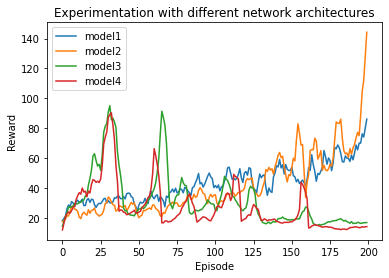

In [ ]:
plot_title = 'Experimentation with different network architectures' 
    
Plot = LearningCurvePlot(title = plot_title)

n_repetitions = 5
smoothing_window = 5

n_episodes = 200

gamma = 0.9
lr = 0.001

for key in models.keys():
    print(f' ============================= START OF {key} =============================')
    current_model = models[key]
    
    results = []

    for rep in range(n_repetitions):
        agent = ReinforceAgent(tf.keras.models.clone_model(current_model), lr, gamma)
        exp_stats = agent.train(n_episodes)
        results.append(exp_stats['episode_overall_reward'])

    # average over repetitions
    results_array = np.array(results)
    results_averaged = np.mean(results_array, axis=0)

    # further smoothing
    results_smoothed = smooth(results_averaged,smoothing_window)

    plot_label = key 
    Plot.add_curve(results_smoothed,label=plot_label)


Plot.save('A3_model_architecture_plots')

### Experimentation with the number of training episodes

Take the best 2 model architectures from th eprevious experiment and train them for a longer period of time to see which one performs better.

In [ ]:
plot_title = 'Experimentation for longer training periods' 
    
Plot = LearningCurvePlot(title = plot_title)

n_repetitions = 3
smoothing_window = 5

n_episodes = 1000

gamma = 0.9
lr = 0.001

models_2 = {'model1': model1, 'model2': model2}

for key in models_2.keys():
    print(f' ============================= START OF {key} =============================')
    current_model = models_2[key]
    
    results = []

    for rep in range(n_repetitions):
        agent = ReinforceAgent(tf.keras.models.clone_model(current_model), lr, gamma)
        exp_stats = agent.train(n_episodes)
        results.append(exp_stats['episode_overall_reward'])

    # average over repetitions
    results_array = np.array(results)
    results_averaged = np.mean(results_array, axis=0)

    # further smoothing
    results_smoothed = smooth(results_averaged,smoothing_window)

    plot_label = key 
    Plot.add_curve(results_smoothed,label=plot_label)


Plot.save('A3_model_architecture_plots_longer_train_period')

 ============================= START OF model1 =============================
 ================== START OF EXPERIMENT ==================
Episode: 0 Score: 14.0
Episode: 1 Score: 37.0
Episode: 2 Score: 15.0
Episode: 3 Score: 49.0
Episode: 4 Score: 12.0
Episode: 5 Score: 77.0
Episode: 6 Score: 31.0
Episode: 7 Score: 40.0
Episode: 8 Score: 16.0
Episode: 9 Score: 25.0
Episode: 10 Score: 27.0
Episode: 11 Score: 41.0
Episode: 12 Score: 31.0
Episode: 13 Score: 20.0
Episode: 14 Score: 21.0
Episode: 15 Score: 23.0
Episode: 16 Score: 21.0
Episode: 17 Score: 32.0
Episode: 18 Score: 20.0
Episode: 19 Score: 21.0
Episode: 20 Score: 25.0
Episode: 21 Score: 22.0
Episode: 22 Score: 12.0
Episode: 23 Score: 13.0
Episode: 24 Score: 31.0
Episode: 25 Score: 35.0
Episode: 26 Score: 44.0
Episode: 27 Score: 30.0
Episode: 28 Score: 18.0
Episode: 29 Score: 29.0
Episode: 30 Score: 21.0
Episode: 31 Score: 23.0
Episode: 32 Score: 19.0
Episode: 33 Score: 30.0
Episode: 34 Score: 46.0
Episode: 35 Score: 18.0
Episode: 3

### Experimenting with different gamma values

 ============================= START OF 0.3 =============================
 ================== START OF EXPERIMENT ==================
Episode: 0 Score: 16.0
Episode: 1 Score: 13.0
Episode: 2 Score: 17.0
Episode: 3 Score: 13.0
Episode: 4 Score: 12.0
Episode: 5 Score: 32.0
Episode: 6 Score: 21.0
 ================== END OF EXPERIMENT ==================
 ================== START OF EXPERIMENT ==================
Episode: 0 Score: 9.0
Episode: 1 Score: 16.0
Episode: 2 Score: 12.0
Episode: 3 Score: 11.0
Episode: 4 Score: 11.0
Episode: 5 Score: 9.0
Episode: 6 Score: 14.0
 ================== END OF EXPERIMENT ==================
 ================== START OF EXPERIMENT ==================
Episode: 0 Score: 12.0
Episode: 1 Score: 17.0
Episode: 2 Score: 42.0
Episode: 3 Score: 21.0
Episode: 4 Score: 53.0
Episode: 5 Score: 21.0
Episode: 6 Score: 16.0
 ================== END OF EXPERIMENT ==================
 ============================= START OF 0.6 =============================
 ================== STA

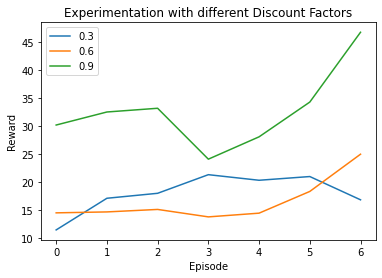

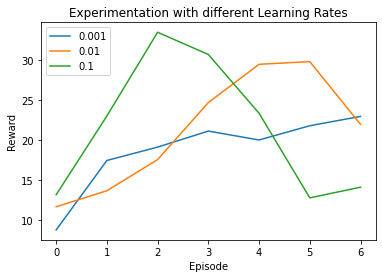

In [11]:
n_repetitions = 5
smoothing_window = 5

n_episodes = 1000

gamma_test = [0.3, 0.6, 0.9]
learning_rate_test = [0.001, 0.01, 0.1]

plot_title = 'Experimentation with different Discount Factors'     
Plot = LearningCurvePlot(title = plot_title)

for gamma in gamma_test:
    print(f' ============================= START OF {gamma} =============================')    
    results = []
    for rep in range(n_repetitions):
        agent = ReinforceAgent(tf.keras.models.clone_model(model1), 0.001, gamma)
        exp_stats = agent.train(n_episodes)
        results.append(exp_stats['episode_overall_reward'])
    # average over repetitions
    results_array = np.array(results)
    results_averaged = np.mean(results_array, axis=0)
    # further smoothing
    results_smoothed = smooth(results_averaged,smoothing_window)
    plot_label = gamma 
    Plot.add_curve(results_smoothed,label=plot_label)
Plot.save('A3_gamma_plots')



### Experimenting with different learning rates

In [ ]:
plot_title = 'Experimentation with different Learning Rates'     
Plot = LearningCurvePlot(title = plot_title)

for lr in learning_rate_test:
    print(f' ============================= START OF {lr} =============================')    
    results = []
    for rep in range(n_repetitions):
        agent = ReinforceAgent(tf.keras.models.clone_model(model1), lr, 0.9)
        exp_stats = agent.train(n_episodes)
        results.append(exp_stats['episode_overall_reward'])
    # average over repetitions
    results_array = np.array(results)
    results_averaged = np.mean(results_array, axis=0)
    # further smoothing
    results_smoothed = smooth(results_averaged,smoothing_window)
    plot_label = lr 
    Plot.add_curve(results_smoothed,label=plot_label)
Plot.save('A3_lr_plots')

# Actor-Critic agent implementation

In [ ]:
import gym
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [1]:
class ActorCriticAgent():

    def __init__(self, model, learning_rate, gamma, optimizer, loss_func):
        self.model = tf.keras.models.clone_model(model)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.optimizer = optimizer
        self.loss_func = loss_func
        
    def train(self, n_episodes, type_of_algorithm):
        action_probabilities_list = []
        critic_values_list = []
        reward_list = []

        experiment_stats = []
        
        for episode in range(n_episodes):
            s = env.reset()
            reward_per_episode = 0

            done = False

            with tf.GradientTape() as tape:
                while not done:
                    # convert state to a tensor of shape = (4,)
                    s = tf.convert_to_tensor(s)
                    # convert state to a tensor of shape = (1, 4)
                    s = tf.expand_dims(s, 0)

                    # get predictions probabilities for actions
                    action_probabilities = self.model(s)[0]

                    # select action based on the above probabilities
                    a = np.random.choice(n_actions, p = np.squeeze(action_probabilities))

                    # get estimated future reward, i.e. critic prediction
                    critic_prediction = self.model(s)[1]

                    # save the actions and critic values
                    action_probabilities_list.append(tf.math.log(action_probabilities[0, a]))
                    critic_values_list.append(critic_prediction[0, 0])

                    # simulate the environment
                    s_next, r, done, _ = env.step(a)
                    reward_per_episode += r
                    reward_list.append(r)                      
                        
                    s = s_next

                    if done:
                        break

                print(f'Episode: {episode}, reward_per_episode: {reward_per_episode}')
                
                # save the results in a list for plotting
                experiment_stats.append(reward_per_episode)

                # compute expected value
                discounted_sum = 0
                returns = []
                for r in reward_list[::-1]:
                    discounted_sum = r + self.gamma * discounted_sum
                    returns.insert(0, discounted_sum)

                # normalize the results
                returns = np.array(returns)
                returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
                returns = returns.tolist()
                
                # apply bootstrapping and baseline subtraction if required:
                if type_of_algorithm == 'vanilla':
                    # compute loss values for the actor and critic models
                    history = zip(action_probabilities_list, critic_values_list, returns)
                    
                elif type_of_algorithm == 'bootstrap':
                    bootstrapped_critic_values_list = []
                    
                    for i in range(len(critic_values_list)):
                        n = len(critic_values_list) - i
                        if n>= 10:
                            bootstrap_value = returns[i+8] + critic_values_list[i]
                        elif n < 10:
                            bootstrap_value = returns[n-1] + critic_values_list[i]
                            
                        bootstrapped_critic_values_list.append(bootstrap_value)
                        
                    history = zip(action_probabilities_list, bootstrapped_critic_values_list, returns)
                    
                elif type_of_algorithm == 'baseline_subtraction':
                    bs_critic_values_list = []
                    
                    for i in range(len(critic_values_list)):
                        baseline_subtraction_value = returns[i] - critic_values_list[i]
                        bs_critic_values_list.append(baseline_subtraction_value)
                        
                    history = zip(action_probabilities_list, bs_critic_values_list, returns)
                    
                elif type_of_algorithm == 'bootstrap_baseline':
                    bbs_critic_values_list = []
                    
                    for i in range(len(critic_values_list)):
                        n = len(critic_values_list) - i
                        if n>= 10:
                            bootstrap_value = returns[i+8] + critic_values_list[i]
                        elif n < 10:
                            bootstrap_value = returns[n-1] + critic_values_list[i]
                            
                        bbs_value = bootstrap_value - critic_values_list[i]
                        bbs_critic_values_list.append(bbs_value)
                        
                    history = zip(action_probabilities_list, bbs_critic_values_list, returns)
                    
                actor_l = []
                critic_l = []

                for log_probability, value, ret in history:
                    advantage_function_value = ret - value

                    actor_l.append(-log_probability * advantage_function_value)

                    loss_c = self.loss_func(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                    critic_l.append(loss_c)

                # perform backpropagation
                total_loss = sum(actor_l) + sum(critic_l)

                grads = tape.gradient(total_loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                # clear the lists for action prabilities, critic values and reward list
                action_probabilities_list.clear()
                critic_values_list.clear()
                reward_list.clear()
                
        return experiment_stats        

### Simple Actor-critic model implementation

In [ ]:
gamma = 0.9
lr = 0.01
# really really really small number
eps = np.finfo(np.float32).eps.item()

env = gym.make('CartPole-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

env.seed(0)

# the first layers are the same for both the actor and the critic model
input_layer = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer1 = tf.keras.layers.Dense(128, activation = 'relu')(input_layer)

# create the output layers for the 2 models
action_output_layer = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer1)
critic_output_layer = tf.keras.layers.Dense(1)(intermediary_layer1) 


# create a model variable that works the 2 models in parallel
model = tf.keras.Model(inputs = input_layer, outputs = [action_output_layer, critic_output_layer])

# create an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
# create a loss function
huber_loss = tf.keras.losses.Huber()

#### Helping function

In [2]:
def average_over_repetitions(reps, model, learning_rate, gamma, optimizer, loss_func, n_episodes, type_of_algorithm):
    m = tf.keras.models.clone_model(model)
    agent = ActorCriticAgent(m, learning_rate, gamma, optimizer, loss_func)
    reward_results = np.empty([reps, n_episodes]) # Result array
    now = time.time()
    
    for rep in range(reps): # Loop over repetitions
        print("----------------------- Repetition " + str(rep) + " -----------------------")
        reward_results[rep] = agent.train(n_episodes, type_of_algorithm)       
          
    learning_curve = np.mean(reward_results,axis=0) # average over repetitions
    learning_curve = smooth(learning_curve,5) # additional smoothing
    return learning_curve

### Define Several Architectures

In [ ]:
# Model 1: one hidden layer of medium size
input_layer1 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer1 = tf.keras.layers.Dense(128, activation = 'relu')(input_layer1)
action_output_layer1 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer1)
critic_output_layer1 = tf.keras.layers.Dense(1)(intermediary_layer1)
model1 = tf.keras.Model(inputs = input_layer1, outputs = [action_output_layer1, critic_output_layer1])

# Model 2: two hidden layers of 128 neurons
input_layer2 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer21 = tf.keras.layers.Dense(128, activation = 'relu')(input_layer2)
intermediary_layer22 = tf.keras.layers.Dense(128, activation = 'relu')(intermediary_layer21)
action_output_layer2 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer22)
critic_output_layer2 = tf.keras.layers.Dense(1)(intermediary_layer22)
model2 = tf.keras.Model(inputs = input_layer2, outputs = [action_output_layer2, critic_output_layer2])

# Model 3: one hidden layer of 128 neurons
input_layer3 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer3 = tf.keras.layers.Dense(128, activation = 'relu')(input_layer3)
action_output_layer3 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer3)
critic_output_layer3 = tf.keras.layers.Dense(1)(intermediary_layer3)
model3 = tf.keras.Model(inputs = input_layer3, outputs = [action_output_layer3, critic_output_layer3])

# Model 4: one hidden layer of 16 neurons
input_layer4 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer4 = tf.keras.layers.Dense(16, activation = 'relu')(input_layer4)
action_output_layer4 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer4)
critic_output_layer4 = tf.keras.layers.Dense(1)(intermediary_layer4)
model4 = tf.keras.Model(inputs = input_layer4, outputs = [action_output_layer4, critic_output_layer4])

# Model 5: one hidden layer of 4 neurons
input_layer5 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer5 = tf.keras.layers.Dense(4, activation = 'relu')(input_layer5)
action_output_layer5 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer5)
critic_output_layer5 = tf.keras.layers.Dense(1)(intermediary_layer5)
model5 = tf.keras.Model(inputs = input_layer5, outputs = [action_output_layer5, critic_output_layer5])

# Model 6: two hidden layers of 64 neurons
input_layer6 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer61 = tf.keras.layers.Dense(64, activation = 'relu')(input_layer6)
intermediary_layer62 = tf.keras.layers.Dense(64, activation = 'relu')(intermediary_layer61)
action_output_layer6 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer62)
critic_output_layer6 = tf.keras.layers.Dense(1)(intermediary_layer62)
model6 = tf.keras.Model(inputs = input_layer6, outputs = [action_output_layer6, critic_output_layer6])

# Model 7: two hidden layers of 256 neurons
input_layer7 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer71 = tf.keras.layers.Dense(256, activation = 'relu')(input_layer7)
intermediary_layer72 = tf.keras.layers.Dense(256, activation = 'relu')(intermediary_layer71)
action_output_layer7 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer72)
critic_output_layer7 = tf.keras.layers.Dense(1)(intermediary_layer72)
model7 = tf.keras.Model(inputs = input_layer7, outputs = [action_output_layer7, critic_output_layer7])

# Model 8: three hidden layers of 128 neurons
input_layer8 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer81 = tf.keras.layers.Dense(256, activation = 'relu')(input_layer8)
intermediary_layer82 = tf.keras.layers.Dense(256, activation = 'relu')(intermediary_layer81)
intermediary_layer83 = tf.keras.layers.Dense(256, activation = 'relu')(intermediary_layer82)
action_output_layer8 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer83)
critic_output_layer8 = tf.keras.layers.Dense(1)(intermediary_layer83)
model8 = tf.keras.Model(inputs = input_layer8, outputs = [action_output_layer8, critic_output_layer8])

models = {'model1': model1, 'model2': model2, 'model3': model3, 'model4': model4, 'model5': model5, 'model6': model6,
          'model7': model7, 'model8': model8}

## Experiment with different architectures and plot the results

In [ ]:
reps = 5
n_episodes = 250
gamma = 0.9
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
huber_loss = tf.keras.losses.Huber()
type_of_algorithm = 'bootstrap_baseline'

Plot = LearningCurvePlot(title = 'Effect of various network architectures')
for key in models.keys():
    print("########## Running for " + key + " ##########")
    learning_curve = average_over_repetitions(reps, models[key], learning_rate, gamma, optimizer, huber_loss, n_episodes,
                                             type_of_algorithm)
    Plot.add_curve(learning_curve, label=key)
        
Plot.save('./architecture_plot.png')

## Experiments with the Learning Rates and plot the results

In [ ]:
reps = 5
n_episodes = 250
gamma = 0.9
lr_values = [0.001, 0.01, 0.1]
huber_loss = tf.keras.losses.Huber()
type_of_algorithm = 'bootstrap_baseline'
model = model5 # change after running architecture experiment

Plot = LearningCurvePlot(title = 'Effect of various learning rates')
for lr in lr_values:
    print("########## Running for learning rate " + str(lr) + " ##########")
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    learning_curve = average_over_repetitions(reps, model, lr, gamma, optimizer, huber_loss, n_episodes,
                                             type_of_algorithm)
    Plot.add_curve(learning_curve, label="lr = " + str(lr))
        
Plot.save('./lr_plot.png')

## Experiment with different discount factors (gamma values)

In [ ]:
reps = 5
n_episodes = 250
gamma_values = [0.3, 0.6, 0.9]
learning_rate = 0.001 # change after running lr experiment
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
huber_loss = tf.keras.losses.Huber()
type_of_algorithm = 'bootstrap_baseline'
model = model5 # change after running architecture experiment

Plot = LearningCurvePlot(title = 'Effect of various gamma values')
for gamma in gamma_values:
    print("########## Running for gamma " + str(gamma) + " ##########")
    learning_curve = average_over_repetitions(reps, model, learning_rate, gamma, optimizer, huber_loss, n_episodes,
                                             type_of_algorithm)
    Plot.add_curve(learning_curve, label="gamma = " + str(gamma))
        
Plot.save('./gamma_plot.png')

## Experiments with Different Versions

- Vanilla Actor-Critic
- Bootstrap Actor-Critic
- Baseline subtraction Actor-Critic
- Bootstrap + baseline subtraction Actor-Critic

In [ ]:
reps = 5
n_episodes = 250
gamma = 0.9
learning_rate = 0.001 # change after running lr experiment
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
huber_loss = tf.keras.losses.Huber()
type_of_algorithm = 'bootstrap_baseline'
model = model5 # change after running architecture experiment
types = ['vanilla', 'bootstrap', 'baseline_subtraction', 'bootstrap_baseline']

Plot = LearningCurvePlot(title = 'Comparison of the four different modes')
for t in types:
    print("########## Running for mode " + t + " ##########")
    learning_curve = average_over_repetitions(reps, model, learning_rate, gamma, optimizer, huber_loss, n_episodes, t)
    Plot.add_curve(learning_curve, label=t)
        
Plot.save('./type_plot.png')

# Compare REINFORCE vs. Actor-Critic

In [ ]:
# REINFORCE
# Model with no hidden layers
model1_re = tf.keras.Sequential()
model1_re.add(tf.keras.layers.Dense(n_actions, activation='softmax', input_shape=(None,n_states)))

# Actor-Critic
# Model 5: one hidden layer of 4 neurons
input_layer5 = tf.keras.layers.Input(shape = (n_states,))
intermediary_layer5 = tf.keras.layers.Dense(4, activation = 'relu')(input_layer5)
action_output_layer5 = tf.keras.layers.Dense(n_actions, activation = 'softmax')(intermediary_layer5)
critic_output_layer5 = tf.keras.layers.Dense(1)(intermediary_layer5)
model5_ac = tf.keras.Model(inputs = input_layer5, outputs = [action_output_layer5, critic_output_layer5])


plot_title = 'Comparison between REINFORCE and Actor-Critic' 
Plot = LearningCurvePlot(title = plot_title)

n_repetitions = 5
smoothing_window = 5
n_episodes = 500
gamma = 0.9
lr = 0.001

model_re = model1_re # Replace with best model for reinforce!!!!!!!!!!!
model_ac = model5_ac 

print(f' ============================= START OF REINFORCE =============================')
current_model = model_re
    
results = []

for rep in range(n_repetitions):
    print("---------------------------- Repetition " + str(rep) + " ----------------------------")
    agent = ReinforceAgent(tf.keras.models.clone_model(current_model), lr, gamma)
    exp_stats = agent.train(n_episodes)
    results.append(exp_stats['episode_overall_reward'])

# average over repetitions
results_array = np.array(results)
results_averaged = np.mean(results_array, axis=0)

# further smoothing
results_smoothed = smooth(results_averaged,smoothing_window)

plot_label = "REINFORCE" 
Plot.add_curve(results_smoothed,label=plot_label)

print(f' ============================= START OF Actor-Critic =============================')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
# create a loss function
huber_loss = tf.keras.losses.Huber()
#results.append(exp_stats['episode_overall_reward'])
learning_curve = average_over_repetitions(n_repetitions, model_ac, 0.01, gamma, optimizer, huber_loss, n_episodes,
                                          'bootstrap_baseline')
Plot.add_curve(learning_curve, label='Actor-Critic')

Plot.save('./comparison.png')